In [1]:
import xarray as xr
import numpy as np
import os.path as op
import sys
import gsw
import scipy.interpolate as naiso
import scipy.integrate as intg
import xgcm.grid as xgd
import importlib

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sys.path.append('../')
import xroms
importlib.reload(xroms)

<module 'xroms' from '../xroms/__init__.py'>

In [3]:
datadir = '../test_data/'

In [4]:
# eta_s, eta_e = (510, 670)
# xi_s, xi_e = (670, 840)

eta_s, eta_e = (560, 620)
xi_s, xi_e = (720, 790)

In [5]:
ds_grid = xr.open_dataset(op.join(datadir, 'AS24th_gridfile.nc'))
ds_grid = ds_grid.isel(eta_psi=slice(eta_s,eta_e-1), eta_rho=slice(eta_s,eta_e),
                       eta_u=slice(eta_s,eta_e), eta_v=slice(eta_s,eta_e-1),
                       xi_psi=slice(xi_s,xi_e-1), xi_rho=slice(xi_s,xi_e), 
                       xi_u=slice(xi_s,xi_e-1), xi_v=slice(xi_s,xi_e))

ds_grid

<xarray.Dataset>
Dimensions:    (bath: 0, eta_psi: 59, eta_rho: 60, eta_u: 60, eta_v: 59, one: 1, s_rho: 32, s_w: 33, xi_psi: 69, xi_rho: 70, xi_u: 69, xi_v: 70)
Dimensions without coordinates: bath, eta_psi, eta_rho, eta_u, eta_v, one, s_rho, s_w, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    xl         (one) float64 9.969e+36
    el         (one) float64 9.969e+36
    depthmin   (one) float64 9.969e+36
    depthmax   (one) float64 9.969e+36
    spherical  (one) |S1 b'T'
    angle      (eta_rho, xi_rho) float64 0.0001108 0.0001108 0.0001108 ...
    h          (eta_rho, xi_rho) float64 3.697e+03 3.695e+03 3.692e+03 ...
    hraw       (bath, eta_rho, xi_rho) float64 
    alpha      (eta_rho, xi_rho) float64 9.969e+36 9.969e+36 9.969e+36 ...
    f          (eta_rho, xi_rho) float64 4.431e-05 4.431e-05 4.431e-05 ...
    pm         (eta_rho, xi_rho) float64 0.0002267 0.0002267 0.0002267 ...
    pn         (eta_rho, xi_rho) float64 0.0002267 0.0002267 0.0002267 ...
    dndx       (eta_rho,

In [6]:
zr = ds_grid.z_rho0[::-1]
zw = ds_grid.z_w0[::-1]
x_r = ds_grid.x_rho
y_r = ds_grid.y_rho
x_v = ds_grid.x_v
y_u = ds_grid.y_u
lon_psi = ds_grid.lon_psi
lat_psi = ds_grid.lat_psi
zr

<xarray.DataArray 'z_rho0' (s_rho: 32, eta_rho: 60, xi_rho: 70)>
[134400 values with dtype=float64]
Dimensions without coordinates: s_rho, eta_rho, xi_rho

In [7]:
H = zw[-1]
print(H)

<xarray.DataArray 'z_w0' (eta_rho: 60, xi_rho: 70)>
array([[-3697.128486, -3695.021864, -3691.973785, ..., -3393.948856,
        -3386.745736, -3375.767202],
       [-3688.767687, -3687.351343, -3684.881305, ..., -3393.284432,
        -3385.296888, -3371.499121],
       [-3681.349127, -3680.141529, -3678.174513, ..., -3391.136032,
        -3382.836527, -3367.001121],
       ..., 
       [-3417.255886, -3413.477477, -3409.870627, ..., -3156.186208,
        -3135.986045, -3093.613509],
       [-3414.966059, -3410.637579, -3406.940499, ..., -3166.60679 ,
        -3144.310918, -3099.134654],
       [-3414.569857, -3410.0412  , -3406.402599, ..., -3170.437364,
        -3144.170909, -3094.526328]])
Dimensions without coordinates: eta_rho, xi_rho


In [8]:
ds = xr.open_dataset(op.join(datadir, 'roms_avg_M01.nc'))

In [9]:
# convert everything that doesn't have a time dimension to coord
def roms_set_coords(ds):
    new_coords = [varname for varname in ds.data_vars
                  if ('time' not in ds[varname].dims)]
    ds_new = ds.set_coords(new_coords)
    return ds_new

roms_set_coords(ds)

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 898, eta_v: 897, s_rho: 32, s_w: 33, time: 10, xi_rho: 1082, xi_u: 1081)
Coordinates:
    spherical   |S1 b'T'
    xl          float32 9.969e+36
    el          float32 9.969e+36
  * xi_rho      (xi_rho) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * xi_u        (xi_u) float32 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * eta_rho     (eta_rho) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * eta_v       (eta_v) float32 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
    Vtransform  float32 2.0
  * s_rho       (s_rho) float32 -0.984375 -0.953125 -0.921875 -0.890625 ...
  * s_w         (s_w) float32 -1.0 -0.96875 -0.9375 -0.90625 -0.875 -0.84375 ...
    sc_r        (s_rho) float32 -0.984375 -0.953125 -0.921875 -0.890625 ...
    sc_w        (s_w) float32 -1.0 -0.96875 -0.9375 -0.90625 -0.875 -0.84375 ...
    Cs_r        (s_rho) float32 -0.896205 -0.719762 -0.577987 -0.464067 ...
    Cs_w        (s_w) float32 -1.0 

In [10]:
ds = ds.isel(eta_rho=slice(eta_s,eta_e),eta_v=slice(eta_s,eta_e-1),
             xi_rho=slice(xi_s,xi_e), xi_u=slice(xi_s,xi_e-1))
# ds = ds.isel(eta_rho=slice(eta_s,eta_e),eta_v=slice(eta_s,eta_e),
#              xi_rho=slice(xi_s,xi_e), xi_u=slice(xi_s,xi_e))
ds

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 60, eta_v: 59, s_rho: 32, s_w: 33, time: 10, xi_rho: 70, xi_u: 69)
Coordinates:
  * xi_rho      (xi_rho) float32 721.0 722.0 723.0 724.0 725.0 726.0 727.0 ...
  * xi_u        (xi_u) float32 721.5 722.5 723.5 724.5 725.5 726.5 727.5 ...
  * eta_rho     (eta_rho) float32 561.0 562.0 563.0 564.0 565.0 566.0 567.0 ...
  * eta_v       (eta_v) float32 561.5 562.5 563.5 564.5 565.5 566.5 567.5 ...
  * s_rho       (s_rho) float32 -0.984375 -0.953125 -0.921875 -0.890625 ...
  * s_w         (s_w) float32 -1.0 -0.96875 -0.9375 -0.90625 -0.875 -0.84375 ...
    lon_rho     (eta_rho, xi_rho) float32 63.05 63.0917 63.1333 63.175 ...
    lat_rho     (eta_rho, xi_rho) float32 17.7364 17.7364 17.7364 17.7364 ...
    lon_u       (eta_rho, xi_u) float32 63.0708 63.1125 63.1542 63.1958 ...
    lat_u       (eta_rho, xi_u) float32 17.7364 17.7364 17.7364 17.7364 ...
    lon_v       (eta_v, xi_rho) float32 63.05 63.0917 63.1333 63.175 63.2167 ...
    lat_v 

In [11]:
# xr.save_mfdataset([ds_grid.load(), ds.load()], [op.join(datadir,'AS24th_gridfile_subsection.nc'), 
#                                   op.join(datadir,'roms_avg_M01_subsection.nc')],
#                   format='NETCDF4', engine='netcdf4')

In [12]:
grid = xgd.Grid(ds, periodic=False)
grid

<xgcm.Grid>
Y Axis (not periodic):
  * center   eta_rho (60) --> inner
  * inner    eta_v (59) --> center
Z Axis (not periodic):
  * center   s_rho (32) --> outer
  * outer    s_w (33) --> center
X Axis (not periodic):
  * center   xi_rho (70) --> inner
  * inner    xi_u (69) --> center
T Axis (not periodic):
  * center   time (10)

In [13]:
# x_r = xr.DataArray(x_r.values, dims=ssh.dims, coords=ssh.coords)
# y_r = xr.DataArray(y_r.values, dims=ssh.dims, coords=ssh.coords)

In [14]:
# zr_relabeled = xr.DataArray(zr.values, dims=['s_rho','lat','lon'],
#                 coords={'s_rho':s.s_rho, 'lat':s.lat_rho[:,0].values, 'lon':s.lon_rho[0].values,
#                        'eta_rho':('lat', zr.eta_rho), 'xi_rho':('lon', zr.xi_rho)}
#                            )
# u_relabeled = xr.DataArray(u.values, dims=['s_rho','lat','lon'],
#                 coords={'s_rho':u.s_rho, 'lat':u.lat_u[:,0].values, 'lon':u.lon_u[0].values,
#                        'eta_rho':('lat', u.eta_rho), 'xi_u':('lon', u.xi_u)}
#                           )
# v_relabeled = xr.DataArray(v.values, dims=['s_rho','lat','lon'],
#                 coords={'s_rho':v.s_rho, 'lat':v.lat_v[:,0].values, 'lon':v.lon_v[0].values,
#                        'eta_v':('lat', v.eta_v), 'xi_rho':('lon', v.xi_rho)}
#                           )
# y_u_relabeled = xr.DataArray(y_u.values, dims=u_relabeled[0].dims, coords=u_relabeled[0].coords)
# x_v_relabeled = xr.DataArray(x_v.values, dims=v_relabeled[0].dims, coords=v_relabeled[0].coords)

# y_u_relabeled

In [15]:
# t_relabeled = xr.DataArray(t.values, dims=['s_rho','lat','lon'],
#                         coords={'s_rho':t.s_rho, 'lat':t.lat_rho[:,0].values, 'lon':t.lon_rho[0].values,
#                                'eta_rho':('lat', t.eta_rho), 'xi_rho':('lon', t.xi_rho)}
#                           )
# s_relabeled = xr.DataArray(s.values, dims=['s_rho','lat','lon'],
#                         coords={'s_rho':s.s_rho, 'lat':s.lat_rho[:,0].values, 'lon':s.lon_rho[0].values,
#                                'eta_rho':('lat', s.eta_rho), 'xi_rho':('lon', s.xi_rho)}
#                           )
# ssh_relabeled = xr.DataArray(ssh.values, dims=['lat','lon'],
#                             coords={'lat':ssh.lat_rho[:,0].values, 'lon':ssh.lon_rho[0].values,
#                                    'eta_rho':('lat', ssh.eta_rho), 'xi_rho':('lon', ssh.xi_rho)}
#                             )

# x_r_relabeled = xr.DataArray(x_r.values, dims=['lat','lon'],
#                             coords={'lat':x_r.lat_rho[:,0].values, 'lon':x_r.lon_rho[0].values,
#                                    'eta_rho':('lat', x_r.eta_rho), 'xi_rho':('lon', x_r.xi_rho)}
#                             )
# y_r_relabeled = xr.DataArray(y_r.values, dims=['lat','lon'],
#                             coords={'lat':y_r.lat_rho[:,0].values, 'lon':y_r.lon_rho[0].values,
#                                    'eta_rho':('lat', y_r.eta_rho), 'xi_rho':('lon', y_r.xi_rho)}
#                             )

In [16]:
# lat_psi_relabled = xr.DataArray(lat_psi.values, dims=['lat','lon'],
#                                coords={'lat':lat_psi[:,0].values,'lon':lon_psi[0].values,
#                                       'eta_psi':('lat', lat_psi.eta_psi), 'xi_psi':('lon', lat_psi.xi_psi)}
#                                )
# lon_psi_relabled = xr.DataArray(lon_psi.values, dims=['lat','lon'],
#                                coords={'lat':lat_psi[:,0].values,'lon':lon_psi[0].values,
#                                       'eta_psi':('lat', lat_psi.eta_psi), 'xi_psi':('lon', lat_psi.xi_psi)}
#                                )

# lat_psi_relabled

In [17]:
# H_relabeled = xr.DataArray(H.values, dims=['lat','lon'],
#                         coords={'lat':ssh.lat_rho[:,0].values, 'lon':ssh.lon_rho[0].values,
#                                'eta_rho':('lat', H.eta_rho), 'xi_rho':('lon', H.xi_rho)}
#                           )

In [18]:
# lats, late = (16.,22.)
# lons, lone = (61.,68.)
# ddeg = 24.**-1

In [19]:
nt=2

In [20]:
udoms = ds.u[:nt,::-1]
vdoms = ds.v[:nt,::-1]
# x_vdoms = ds_grid.x_v
# y_udoms = ds_grid.y_u
# udoms = u_relabeled.sel(lon=slice(lons-.5*ddeg,lone), lat=slice(lats,late))
# vdoms = v_relabeled.sel(lon=slice(lons,lone), lat=slice(lats,late))
# x_vdoms = x_v_relabeled.sel(lon=slice(lons,lone), lat=slice(lats,late))
# y_udoms = y_u_relabeled.sel(lon=slice(lons-.5*ddeg,lone), lat=slice(lats,late))

udoms

<xarray.DataArray 'u' (time: 2, s_rho: 32, eta_rho: 60, xi_u: 69)>
[264960 values with dtype=float32]
Coordinates:
  * xi_u     (xi_u) float32 721.5 722.5 723.5 724.5 725.5 726.5 727.5 728.5 ...
  * eta_rho  (eta_rho) float32 561.0 562.0 563.0 564.0 565.0 566.0 567.0 ...
  * s_rho    (s_rho) float32 -0.015625 -0.046875 -0.078125 -0.109375 ...
    lon_u    (eta_rho, xi_u) float32 63.0708 63.1125 63.1542 63.1958 63.2375 ...
    lat_u    (eta_rho, xi_u) float32 17.7364 17.7364 17.7364 17.7364 17.7364 ...
  * time     (time) float32 2.80066e+08 2.80325e+08
Attributes:
    long_name:      averaged u-momentum component
    units:          meter second-1
    field:          u-velocity, scalar, series
    standard_name:  sea_water_x_velocity_at_u_location

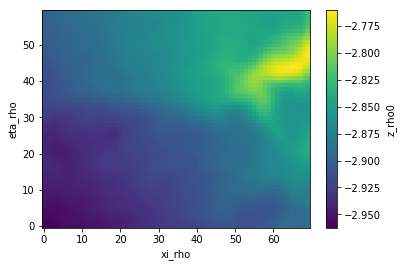

In [21]:
zr[0].plot()

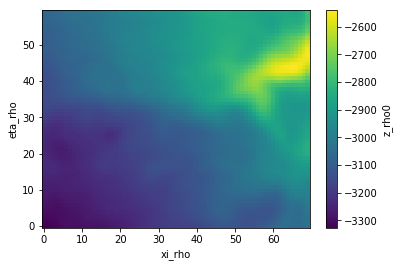

In [22]:
zr[-1].plot()

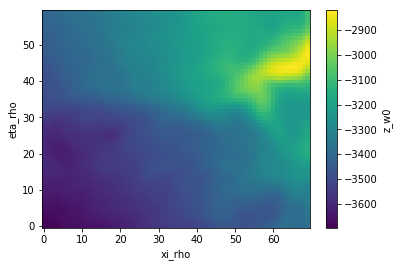

In [23]:
H.plot()

In [24]:
# zdoms = ds_grid.z_rho0
tdoms = ds.temp[:nt,::-1]
sdoms = ds.salt[:nt,::-1]
sshdoms = ds.zeta[:nt]

sshdoms

<xarray.DataArray 'zeta' (time: 2, eta_rho: 60, xi_rho: 70)>
array([[[-0.142623, -0.139747, ..., -0.105304, -0.110714],
        [-0.149748, -0.147139, ..., -0.110593, -0.116689],
        ..., 
        [-0.114116, -0.111145, ..., -0.03742 , -0.036922],
        [-0.116371, -0.113189, ..., -0.037657, -0.03732 ]],

       [[-0.118759, -0.11632 , ..., -0.119138, -0.121943],
        [-0.124044, -0.121404, ..., -0.128842, -0.131954],
        ..., 
        [-0.103212, -0.101345, ..., -0.017144, -0.01442 ],
        [-0.102647, -0.100266, ..., -0.01678 , -0.014355]]], dtype=float32)
Coordinates:
  * xi_rho   (xi_rho) float32 721.0 722.0 723.0 724.0 725.0 726.0 727.0 ...
  * eta_rho  (eta_rho) float32 561.0 562.0 563.0 564.0 565.0 566.0 567.0 ...
    lon_rho  (eta_rho, xi_rho) float32 63.05 63.0917 63.1333 63.175 63.2167 ...
    lat_rho  (eta_rho, xi_rho) float32 17.7364 17.7364 17.7364 17.7364 ...
  * time     (time) float32 2.80066e+08 2.80325e+08
Attributes:
    long_name:      averaged free-s

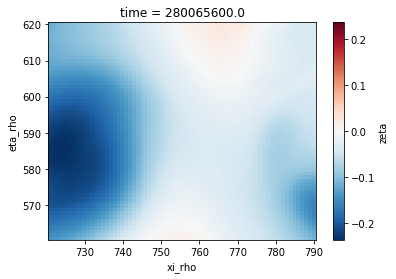

In [25]:
sshdoms[0].plot()

In [26]:
pres = xr.DataArray(gsw.p_from_z(zr.values, 
                                 sshdoms.lat_rho.values[np.newaxis,:,:]),
                    dims=zr.dims, coords=zr.coords
                   )

(32, 60, 70)


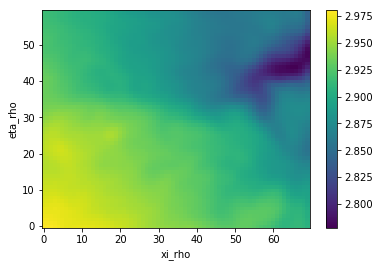

In [27]:
print(pres.shape)
pres[0].plot()

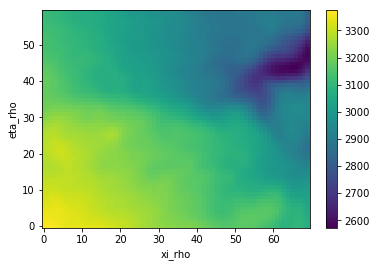

In [28]:
pres[-1].plot()

In [29]:
absS = gsw.SA_from_SP(sdoms.values, pres.values, 
                      sdoms.lon_rho.values[np.newaxis,np.newaxis,:,:], 
                      sdoms.lat_rho.values[np.newaxis,np.newaxis,:,:]
                     )
consT = gsw.CT_from_pt(absS, tdoms)
rho = xr.DataArray(gsw.rho(absS, consT, 0.), dims=sdoms.dims, coords=sdoms.coords)

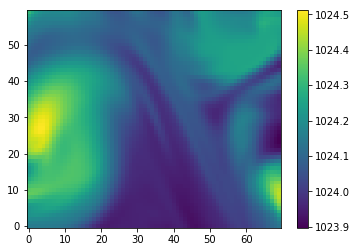

In [30]:
plt.imshow(rho[0,0], origin='bottom')
plt.colorbar()

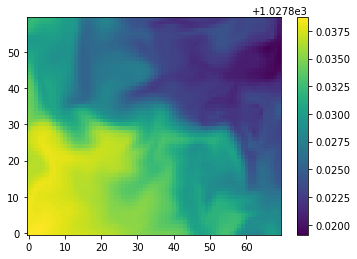

In [31]:
plt.imshow(rho[0,-1], origin='bottom')
plt.colorbar()

In [32]:
zi = np.array([0,1,3,5,7,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,
            95,100,110,115,120,125,130,135,140,145,150,155,160,165,170,175,
            180,185,190,195,200,210,220,240,260,280,300,320,340,360,380,
            400,450,500,550,600,650,700,750,800,850,900,950,1000,1100,1200,
            1300,1400,1500,1700,2000,2500,3000,3500,4000,4500], dtype=float
             )

In [33]:
absSz = xroms.sig2z(xr.DataArray(absS, dims=sdoms.dims, 
                              coords=sdoms.coords)[:,::-1], zr[::-1].values, zi
                )
consTz = xroms.sig2z(xr.DataArray(consT, dims=tdoms.dims, 
                               coords=tdoms.coords)[:,::-1], zr[::-1].values, zi
                 )
rhoz = xroms.sig2z(xr.DataArray(rho, dims=tdoms.dims, 
                               coords=tdoms.coords)[:,::-1], zr[::-1].values, zi
                 )
presz = xroms.sig2z(xr.DataArray(pres, dims=zr.dims, 
                              coords=zr.coords)[::-1], zr[::-1].values, zi
                )

In [34]:
np.diff(np.nanmean(presz,axis=(-2,-1)))

/Users/uchidatakaya/anaconda/envs/xroms/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


array([   1.00610872,    2.01221744,    2.01221744,    2.01221744,
          3.01836369,    5.03069928,    5.03083455,    5.03096609,
          5.0310827 ,    5.03119235,    5.03131574,    5.03146704,
          5.03156101,    5.0316906 ,    5.03183349,    5.03191581,
          5.03209288,    5.03215819,    5.03233794,    5.03241912,
          5.03254687,    5.03271645,    5.03275956,   10.06602765,
          5.03312347,    5.03330123,    5.03347933,    5.03351141,
          5.033617  ,    5.03382533,    5.03397733,    5.03400478,
          5.03409714,    5.03427805,    5.03448864,    5.03457453,
          5.03459997,    5.03470686,    5.03487304,    5.03508984,
          5.03524691,    5.03528275,   10.07075502,   10.07139527,
         20.14440506,   20.14613901,   20.14845975,   20.14983662,
         20.15266135,   20.15386909,   20.1558323 ,   20.15874183,
         20.15984675,   50.40892421,   50.42018311,   50.43473304,
         50.44398761,   50.45908294,   50.46982497,   50.48049

In [35]:
absSz

<xarray.DataArray (time: 2, z: 78, eta_rho: 60, xi_rho: 70)>
array([[[[ 36.384708, ...,  36.601495],
         ..., 
         [ 36.575169, ...,  36.540428]],

        ..., 
        [[       nan, ...,        nan],
         ..., 
         [       nan, ...,        nan]]],


       [[[ 36.403927, ...,  36.656757],
         ..., 
         [ 36.396222, ...,  36.602249]],

        ..., 
        [[       nan, ...,        nan],
         ..., 
         [       nan, ...,        nan]]]])
Coordinates:
  * time     (time) float32 2.80066e+08 2.80325e+08
  * z        (z) float64 -0.0 -1.0 -3.0 -5.0 -7.0 -10.0 -15.0 -20.0 -25.0 ...
  * eta_rho  (eta_rho) float32 561.0 562.0 563.0 564.0 565.0 566.0 567.0 ...
  * xi_rho   (xi_rho) float32 721.0 722.0 723.0 724.0 725.0 726.0 727.0 ...

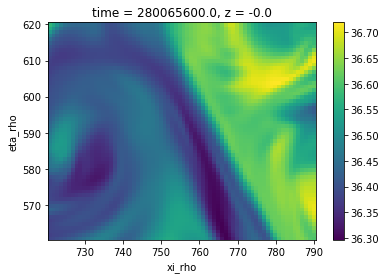

In [36]:
absSz[0,0].plot()

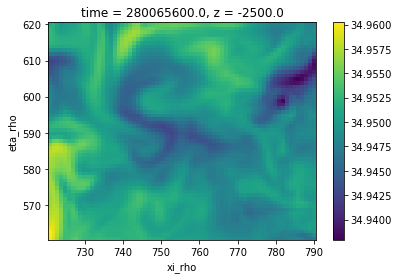

In [37]:
absSz[0,-5].plot()

/Users/uchidatakaya/anaconda/envs/xroms/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


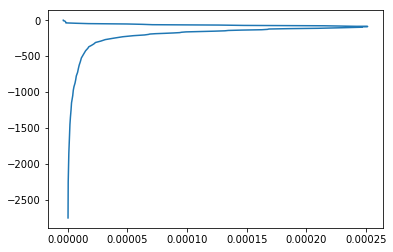

In [38]:
plt.plot(-9.8 * np.nanmean(rhoz,axis=(0,-2,-1))[0]**-1 
         * np.diff(np.nanmean(rhoz,axis=(0,-2,-1)))/np.diff(-zi), -.5*(zi[1:]+zi[:-1]))

In [39]:
N2, pN2 = gsw.Nsquared(np.nanmean(absSz,axis=(0,-2,-1)), np.nanmean(consTz,axis=(0,-2,-1)), 
                       np.nanmean(presz,axis=(-2,-1)), lat=np.nanmean(tdoms.lat_rho.values)
                      )
zN2 = gsw.z_from_p(pN2, tdoms.lat_rho.mean().values)

/Users/uchidatakaya/anaconda/envs/xroms/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/uchidatakaya/anaconda/envs/xroms/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


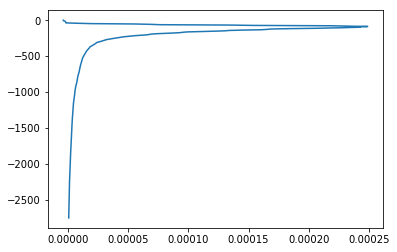

In [40]:
plt.plot(N2, zN2)

$$ b = - g \frac{\rho - \rho_0}{\rho_0} $$

where $\rho_0(z) = \overline{\rho(z)}^{xy}$

In [41]:
g = 9.8
b = xr.DataArray(-g * (rho.values - rho.mean(axis=(-1,-2)).values[:,:,np.newaxis,np.newaxis]) 
                       / rho.mean(axis=(-1,-2)).values[:,:,np.newaxis,np.newaxis], 
                 dims=tdoms.dims, coords=tdoms.coords)

b

<xarray.DataArray (time: 2, s_rho: 32, eta_rho: 60, xi_rho: 70)>
array([[[[ -2.505680e-04, ...,  -8.026759e-05],
         ..., 
         [ -1.707887e-03, ...,  -1.036494e-03]],

        ..., 
        [[ -9.127007e-05, ...,   9.347463e-07],
         ..., 
         [ -2.871958e-05, ...,   8.085975e-05]]],


       [[[  1.249504e-04, ...,  -9.147990e-04],
         ..., 
         [ -5.094731e-05, ...,  -5.654346e-04]],

        ..., 
        [[ -9.208765e-05, ...,   5.848433e-06],
         ..., 
         [ -3.126534e-05, ...,   8.338898e-05]]]])
Coordinates:
  * xi_rho   (xi_rho) float32 721.0 722.0 723.0 724.0 725.0 726.0 727.0 ...
  * eta_rho  (eta_rho) float32 561.0 562.0 563.0 564.0 565.0 566.0 567.0 ...
  * s_rho    (s_rho) float32 -0.015625 -0.046875 -0.078125 -0.109375 ...
    lon_rho  (eta_rho, xi_rho) float32 63.05 63.0917 63.1333 63.175 63.2167 ...
    lat_rho  (eta_rho, xi_rho) float32 17.7364 17.7364 17.7364 17.7364 ...
  * time     (time) float32 2.80066e+08 2.80325e+08

In [42]:
# # For vertical finite differences...
# N = zdoms.shape
# dzr = np.zeros((N[0]+1, N[1], N[2]))
# dzr[0] = -zdoms[0].values
# dzr[1:-1] = -zdoms.diff('s_rho').values
# dzr[-1] = -Hdoms + zdoms[-1].values
# # dzr = np.array([[-zr[0]], [-np.diff(zr, axis=0)], [-H+zr[-1]]])  # nz+1
# # dzr
# dzp = np.zeros(N);
# dzp[0] = dzr[0] + dzr[1]*.5  
# dzp[1:-1] = .5*(dzr[1:-2]+dzr[2:-1])
# dzp[-1] = dzr[-2]*.5 + dzr[-1]

# # interface positions between rho points, where b will be 
# # interpolated 
# zp = np.zeros_like(dzr)
# zp[0] = zdoms[0]*.5
# zp[1:] = -np.cumsum(dzp, axis=0) # zp(nz+1) = -H

In [43]:
# zp[-1]

In [44]:
# N_b = zp.shape
# N2_intrp = np.zeros_like(zp)
# N2_intrp[:] = np.nan
# b_intrp = N2_intrp.copy()

# fN = naiso.interp1d(zN2, N2, fill_value='extrapolate')

# for j in range(N_b[-2]):
#     for i in range(N_b[-1]):
#         N2_intrp[:,j,i] = fN(zp[:,j,i])
#         fb = naiso.interp1d(zdoms[:,j,i], b[:,j,i], fill_value='extrapolate')
#         b_intrp[:,j,i] = fb(zp[:,j,i])

In [45]:
# b_intrp = xr.DataArray(b_intrp, dims=['s','lat','lon'],
#                       coords={'s':range(N_b[0]), 'lat':b.lat.values, 'lon':b.lon.values})
# N2_intrp = xr.DataArray(N2_intrp, dims=b_intrp.dims, coords=b_intrp.coords)

In [46]:
# zp = xr.DataArray(zp, dims=b_intrp.dims, coords=b_intrp.coords)

In [47]:
# b_intrp[0].plot()

In [48]:
f = gsw.earth.f(tdoms.lat_rho.values)
f0 = f.mean()

In [49]:
# lat_psi_doms = lat_psi_relabled.sel(lon=slice(lons+.5*ddeg,lone), 
#                                     lat=slice(lats+.5*ddeg,late))
# lon_psi_doms = lon_psi_relabled.sel(lon=slice(lons+.5*ddeg,lone), 
#                                     lat=slice(lats+.5*ddeg,late))

# lat_psi_doms

In [50]:
psi = xr.DataArray(np.zeros_like(b), dims=b.dims, coords=b.coords)
for t in range(nt):
    psi[t] = xroms.geo_streamfunc(b[t], zr, f0, eta=sshdoms[t], ax=0)
# psi = xr.DataArray(psi.values, dims=['s_rho','eta_rho','xi_rho'],
#                   coords={'s_rho':psi.s_rho.values, 'eta_rho':psi.eta_rho.values, 'xi_rho':psi.xi_rho.values,
#                          'lat':('eta_rho',psi.lat.values), 'lon':('xi_rho',psi.lon.values),
#                          'y':(('eta_rho','xi_rho'),y_rdoms.values), 'x':(('eta_rho','xi_rho'),x_rdoms.values)}
#                   )
psi

<xarray.DataArray (time: 2, s_rho: 32, eta_rho: 60, xi_rho: 70)>
array([[[[-29585.822266, ..., -22966.669922],
         ..., 
         [-24140.044922, ...,  -7741.710938]],

        ..., 
        [[  1709.287798, ..., -16019.054453],
         ..., 
         [-11353.393748, ..., -29498.010868]]],


       [[[-24635.419922, ..., -25295.988281],
         ..., 
         [-21293.267578, ...,  -2977.733643]],

        ..., 
        [[  2866.151327, ..., -15027.621708],
         ..., 
         [ -9160.711102, ..., -28358.499877]]]])
Coordinates:
  * xi_rho   (xi_rho) float32 721.0 722.0 723.0 724.0 725.0 726.0 727.0 ...
  * eta_rho  (eta_rho) float32 561.0 562.0 563.0 564.0 565.0 566.0 567.0 ...
  * s_rho    (s_rho) float32 -0.015625 -0.046875 -0.078125 -0.109375 ...
    lon_rho  (eta_rho, xi_rho) float32 63.05 63.0917 63.1333 63.175 63.2167 ...
    lat_rho  (eta_rho, xi_rho) float32 17.7364 17.7364 17.7364 17.7364 ...
  * time     (time) float32 2.80066e+08 2.80325e+08

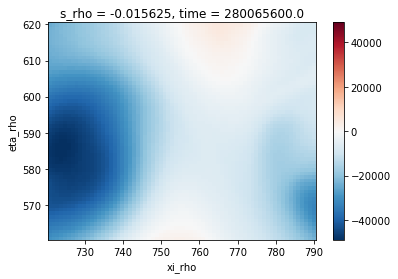

In [51]:
psi[0,0].plot()

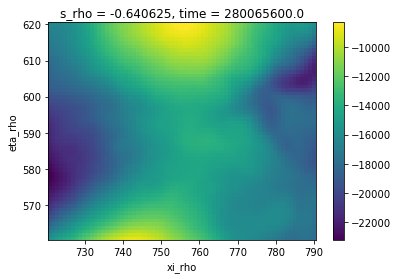

In [52]:
psi[0,20].plot()

In [53]:
# print(b.shape, udoms.shape, vdoms.shape)
# utest = udoms.isel(lat=slice(None,-1))
# print(utest.shape)

In [54]:
grid.interp(grid.diff(ds_grid.y_rho.load(),'Y'),'Y',boundary='fill')

<xarray.DataArray (eta_rho: 60, xi_rho: 70)>
array([[ 2205.217898,  2205.217898,  2205.217898, ...,  2205.217898,
         2205.217898,  2205.217898],
       [ 4409.946725,  4409.946725,  4409.946725, ...,  4409.946725,
         4409.946725,  4409.946725],
       [ 4408.967632,  4408.967632,  4408.967632, ...,  4408.967632,
         4408.967632,  4408.967632],
       ..., 
       [ 4352.261495,  4352.261495,  4352.261495, ...,  4352.261495,
         4352.261495,  4352.261495],
       [ 4351.179814,  4351.179814,  4351.179814, ...,  4351.179814,
         4351.179814,  4351.179814],
       [ 2175.319266,  2175.319266,  2175.319266, ...,  2175.319266,
         2175.319266,  2175.319266]])
Coordinates:
  * eta_rho  (eta_rho) float32 561.0 562.0 563.0 564.0 565.0 566.0 567.0 ...
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...

In [55]:
grid.diff(psi[0],'Y')

<xarray.DataArray (s_rho: 32, eta_v: 59, xi_rho: 70)>
array([[[-1478.005859, -1533.412109, ..., -1097.107422, -1239.373047],
        [-1500.855469, -1586.546875, ..., -1200.009766, -1393.134766],
        ..., 
        [ -334.341797,  -272.953125, ...,    76.024414,    55.615723],
        [ -467.785156,  -424.064453, ...,   -49.052734,   -82.586426]],

       [[-1459.115343, -1516.140418, ..., -1087.848349, -1219.132181],
        [-1473.224595, -1557.248418, ..., -1178.870849, -1354.042359],
        ..., 
        [ -289.896605,  -235.446922, ...,    49.323282,    28.578548],
        [ -419.436394,  -378.995177, ...,   -51.984134,   -89.70125 ]],

       ..., 
       [[ -517.8668  ,  -491.459155, ...,   -53.754547,  -164.717362],
        [ -472.835194,  -473.991478, ...,   -49.059429,  -125.675324],
        ..., 
        [ -162.205466,  -160.085682, ...,   451.19973 ,   307.610235],
        [  -55.661739,   -71.488287, ...,    29.555662,  -200.299461]],

       [[ -509.230852,  -464.7897

In [56]:
ug, vg = xroms.geo_vel(ds, ds_grid, psi)

ug

<xarray.DataArray (time: 2, s_rho: 32, eta_rho: 60, xi_rho: 70)>
array([[[[ 0.167558, ...,  0.140505],
         ..., 
         [ 0.053761, ...,  0.009491]],

        ..., 
        [[ 0.05773 , ...,  0.018695],
         ..., 
         [ 0.007814, ...,  0.022257]]],


       [[[ 0.124293, ...,  0.235418],
         ..., 
         [-0.013468, ..., -0.001552]],

        ..., 
        [[ 0.056634, ...,  0.009203],
         ..., 
         [ 0.003754, ...,  0.017117]]]])
Coordinates:
  * time     (time) float32 2.80066e+08 2.80325e+08
  * s_rho    (s_rho) float32 -0.015625 -0.046875 -0.078125 -0.109375 ...
  * eta_rho  (eta_rho) float32 561.0 562.0 563.0 564.0 565.0 566.0 567.0 ...
  * xi_rho   (xi_rho) float32 721.0 722.0 723.0 724.0 725.0 726.0 727.0 ...

In [57]:
y = xr.DataArray(ds_grid.y_rho.values, dims=psi[0,0].dims, coords=psi[0,0].coords)
x = xr.DataArray(ds_grid.x_rho.values, dims=psi[0,0].dims, coords=psi[0,0].coords)
# x = ds_grid.x_rho.load()
# y = ds_grid.y_rho.load()

x

<xarray.DataArray (eta_rho: 60, xi_rho: 70)>
array([[ 3175514.14798 ,  3179924.584297,  3184335.020614, ...,  3471013.381195,
         3475423.817512,  3479834.253829],
       [ 3174809.884297,  3179219.342469,  3183628.800642, ...,  3470243.581863,
         3474653.040036,  3479062.498209],
       [ 3174104.254133,  3178512.732264,  3182921.210394, ...,  3469472.288892,
         3473880.767023,  3478289.245154],
       ..., 
       [ 3133239.547024,  3137591.268617,  3141942.99021 , ...,  3424804.893761,
         3429156.615354,  3433508.336947],
       [ 3132460.101046,  3136810.740076,  3141161.379105, ...,  3423952.916005,
         3428303.555034,  3432654.194063],
       [ 3131679.386402,  3136028.941106,  3140378.495809, ...,  3423099.551526,
         3427449.106229,  3431798.660933]])
Coordinates:
  * xi_rho   (xi_rho) float32 721.0 722.0 723.0 724.0 725.0 726.0 727.0 ...
  * eta_rho  (eta_rho) float32 561.0 562.0 563.0 564.0 565.0 566.0 567.0 ...
    s_rho    float32 -0.015625


In [58]:
dug_dy = grid.interp(grid.diff(ug,'Y') / grid.diff(y,'Y'), 'Y', boundary='fill')
dvg_dx = grid.interp(grid.diff(vg,'X') / grid.diff(x,'X'), 'X', boundary='fill')
dug_dx = grid.interp(grid.diff(ug,'X') / grid.diff(x,'X'), 'X', boundary='fill')
dvg_dy = grid.interp(grid.diff(vg,'Y') / grid.diff(y,'Y'), 'Y', boundary='fill')

dug_dx

<xarray.DataArray (time: 2, s_rho: 32, eta_rho: 60, xi_rho: 70)>
array([[[[  7.120913e-07, ...,   1.828424e-06],
         ..., 
         [ -5.776029e-07, ...,   4.430202e-07]],

        ..., 
        [[ -5.711658e-07, ...,   1.260258e-06],
         ..., 
         [ -5.216881e-08, ...,   3.010636e-06]]],


       [[[ -5.358758e-07, ...,   8.187745e-07],
         ..., 
         [ -1.409676e-06, ...,   8.193910e-07]],

        ..., 
        [[ -5.251347e-07, ...,   1.145390e-06],
         ..., 
         [ -2.728957e-07, ...,   2.906633e-06]]]])
Coordinates:
  * time     (time) float32 2.80066e+08 2.80325e+08
  * s_rho    (s_rho) float32 -0.015625 -0.046875 -0.078125 -0.109375 ...
  * eta_rho  (eta_rho) float32 561.0 562.0 563.0 564.0 565.0 566.0 567.0 ...
  * xi_rho   (xi_rho) float32 721.0 722.0 723.0 724.0 725.0 726.0 727.0 ...

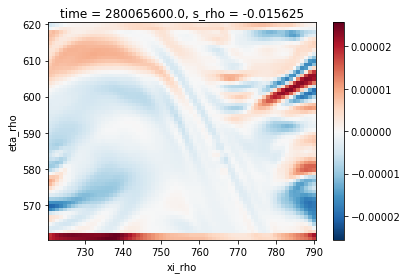

In [59]:
dug_dy[0,0].plot()

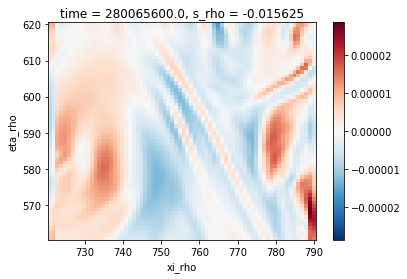

In [60]:
dvg_dx[0,0].plot()

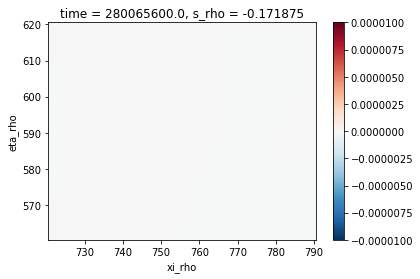

In [61]:
(dug_dx + dvg_dy)[0,5].plot(vmax=1e-5)

In [62]:
zeta_test = dvg_dy - dug_dy
zeta_test

<xarray.DataArray (time: 2, s_rho: 32, eta_rho: 60, xi_rho: 70)>
array([[[[ -2.000410e-05, ...,  -1.974083e-05],
         ..., 
         [  4.994489e-06, ...,  -1.177064e-06]],

        ..., 
        [[ -5.553573e-06, ...,  -2.612537e-06],
         ..., 
         [  2.193649e-06, ...,  -7.364205e-06]]],


       [[[ -1.481467e-05, ...,  -2.503421e-05],
         ..., 
         [ -2.271410e-06, ...,  -2.301054e-06]],

        ..., 
        [[ -5.324736e-06, ...,  -2.569987e-06],
         ..., 
         [  1.245593e-06, ...,  -7.805134e-06]]]])
Coordinates:
  * time     (time) float32 2.80066e+08 2.80325e+08
  * s_rho    (s_rho) float32 -0.015625 -0.046875 -0.078125 -0.109375 ...
  * eta_rho  (eta_rho) float32 561.0 562.0 563.0 564.0 565.0 566.0 567.0 ...
  * xi_rho   (xi_rho) float32 721.0 722.0 723.0 724.0 725.0 726.0 727.0 ...

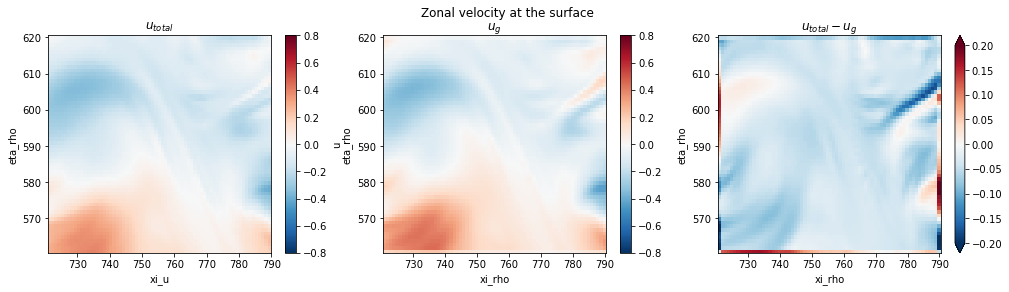

In [63]:
fig = plt.figure(figsize=(17,4))
ax1 = fig.add_subplot(131)
udoms[0,0].plot(vmax=.8)
ax1.set_title(r"$u_{total}$")
ax2= fig.add_subplot(132)
ug[0,0].plot(vmax=.8)
ax2.set_title(r"$u_g$")
ax3 = fig.add_subplot(133)
(grid.interp(udoms[0,0],'X',boundary='fill') - ug[0,0]).plot(vmax=.2)
ax3.set_title(r"$u_{total} - u_g$")
# fig.colorbar(ca)

plt.suptitle('Zonal velocity at the surface')

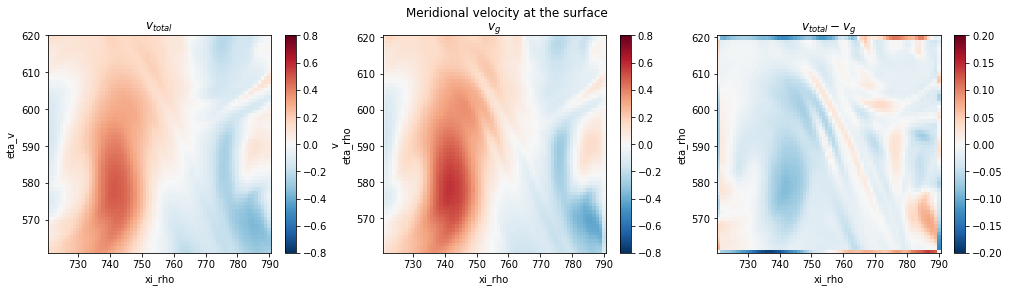

In [64]:
fig = plt.figure(figsize=(17,4))
ax1 = fig.add_subplot(131)
vdoms[0,0].plot(vmax=.8)
ax1.set_title(r"$v_{total}$")
ax2= fig.add_subplot(132)
vg[0,0].plot(vmax=.8)
ax2.set_title(r"$v_g$")
ax3 = fig.add_subplot(133)
(grid.interp(vdoms[0,0],'Y',boundary='fill') - vg[0,0]).plot(vmax=.2)
ax3.set_title(r"$v_{total} - v_g$")
# fig.colorbar(ca)

plt.suptitle('Meridional velocity at the surface')

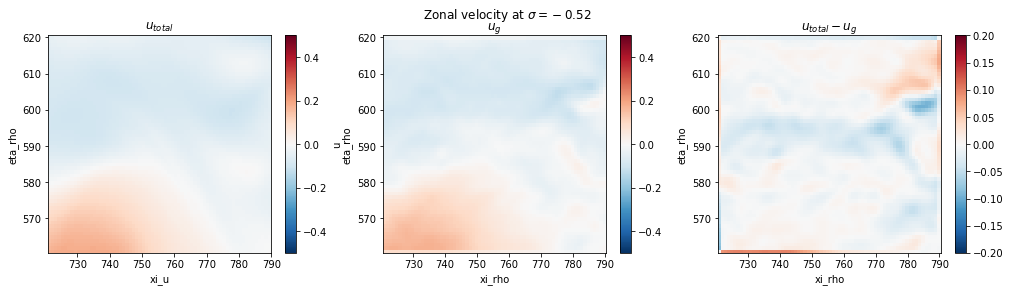

In [65]:
fig = plt.figure(figsize=(17,4))
ax1 = fig.add_subplot(131)
udoms[0,16].plot(vmax=.5)
ax1.set_title(r"$u_{total}$")
ax2= fig.add_subplot(132)
ug[0,16].plot(vmax=.5)
ax2.set_title(r"$u_g$")
ax3 = fig.add_subplot(133)
(grid.interp(udoms[0,16],'X',boundary='fill') - ug[0,16]).plot(vmax=.2)
ax3.set_title(r"$u_{total} - u_g$")
# fig.colorbar(ca)

plt.suptitle("Zonal velocity at $\sigma=-0.52$")

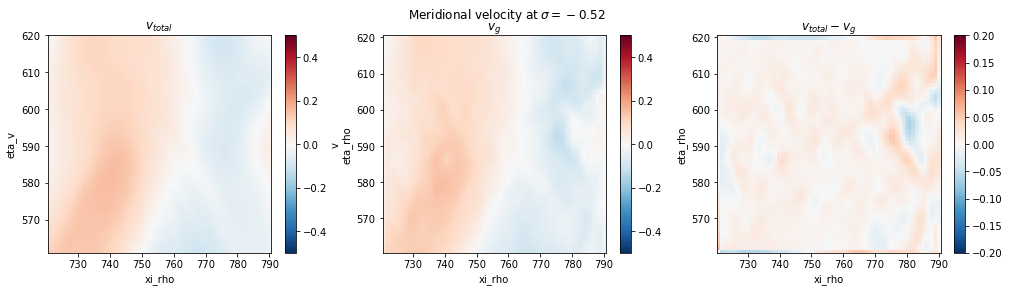

In [66]:
fig = plt.figure(figsize=(17,4))
ax1 = fig.add_subplot(131)
vdoms[0,16].plot(vmax=.5)
ax1.set_title(r"$v_{total}$")
ax2= fig.add_subplot(132)
vg[0,16].plot(vmax=.5)
ax2.set_title(r"$v_g$")
ax3 = fig.add_subplot(133)
(grid.interp(vdoms[0,16],'Y',boundary='fill') - vg[0,16]).plot(vmax=.2)
ax3.set_title(r"$v_{total} - v_g$")
# fig.colorbar(ca)

plt.suptitle("Meridional velocity at $\sigma=-0.52$")

In [67]:
# udoms = xr.DataArray(udoms.values, dims=['s_rho','eta_rho','xi_u'],
#                     coords={'s_rho':udoms.s_rho.values,
#                            'eta_rho':udoms.eta_rho.values,'xi_u':udoms.xi_u.values}
#                     )
# vdoms = xr.DataArray(vdoms.values, dims=['s_rho','eta_v','xi_rho'],
#                     coords={'s_rho':vdoms.s_rho.values,
#                            'eta_v':vdoms.eta_v.values,'xi_rho':vdoms.xi_rho.values}
#                     )
# y_udoms = xr.DataArray(y_udoms.values, dims=['eta_rho','xi_u'],
#                       coords={'eta_rho':y_udoms.eta_rho.values,'xi_u':y_udoms.xi_u.values}
#                       )
# x_vdoms = xr.DataArray(x_vdoms.values, dims=['eta_v','xi_rho'],
#                       coords={'eta_v':x_vdoms.eta_v.values,'xi_rho':x_vdoms.xi_rho.values}
#                       )

In [68]:
# dim = ['s_rho','lat','lon']
# coord = {'s_rho':b.s_rho.values,'lat':b.lat[1:-1].values,'lon':b.lon[1:-1].values}
zeta_g = xroms.rel_vorticity(ug, vg, ds, ds_grid, 
                             xname='x_rho', yname='y_rho', shift=False
                            )
zeta_g

<xarray.DataArray (time: 2, s_rho: 32, eta_rho: 60, xi_rho: 70)>
array([[[[ -1.108834e-05, ...,  -2.909297e-06],
         ..., 
         [  1.417353e-05, ...,  -5.842439e-07]],

        ..., 
        [[ -8.723151e-06, ...,   4.520013e-06],
         ..., 
         [  1.378028e-06, ...,   1.450573e-05]]],


       [[[ -8.622981e-06, ...,  -1.422300e-05],
         ..., 
         [  2.443923e-06, ...,  -9.015445e-06]],

        ..., 
        [[ -8.232218e-06, ...,   4.935501e-06],
         ..., 
         [ -5.992116e-07, ...,   1.388988e-05]]]])
Coordinates:
  * time     (time) float32 2.80066e+08 2.80325e+08
  * s_rho    (s_rho) float32 -0.015625 -0.046875 -0.078125 -0.109375 ...
  * eta_rho  (eta_rho) float32 561.0 562.0 563.0 564.0 565.0 566.0 567.0 ...
  * xi_rho   (xi_rho) float32 721.0 722.0 723.0 724.0 725.0 726.0 727.0 ...

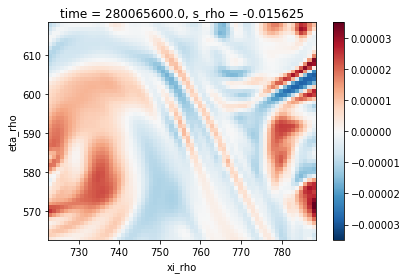

In [69]:
zeta_g[0,0,2:-2,2:-2].plot()

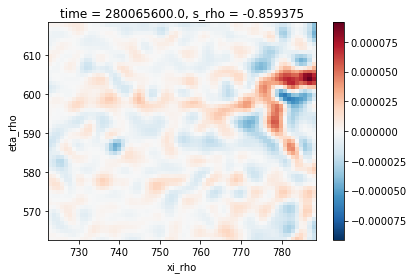

In [70]:
zeta_g[0,-5,2:-2,2:-2].plot()

In [71]:
# print(zeta.shape, b_intrp[:,1:-1,1:-1].shape, zdoms[:5,1:-1,1:-1].shape, 
#       sshdoms[1:-1,1:-1].shape, N2_intrp[:,1:-1,1:-1].shape)

In [72]:
# zeta_test = .25 * (zeta + zeta.shift(lat_psi=-1) + zeta.shift(lon_psi=-1)
#                  + zeta.shift(lat_psi=-1, lon_psi=-1)
#                  ).isel(lat_psi=slice(None,-1), lon_psi=slice(None,-1)
#                        ).values
# qtest = (f[np.newaxis,1:-1,np.newaxis] + zeta_test
#         + f0 * ((b_intrp[:,1:-1,1:-1] * N2_intrp[:,1:-1,1:-1]**-1).diff('s').values
#                 * zp[:,1:-1,1:-1].diff('s').values**-1
#                )
#         )

In [73]:
# plt.imshow(qtest[0], origin='bottom')
# plt.colorbar()

In [74]:
# dim = ['s', 'lat', 'lon']
# s = np.zeros(33)
# s[1:] = zeta.s_rho.values
# coord = {'s':s, 'lat':b_intrp.lat[1:-1].values, 'lon':b_intrp.lon[1:-1].values}

In [75]:
# q = xm.qgpv(zeta[:], b_intrp[:,1:-1,1:-1], zp[:,1:-1,1:-1], 
#             N2_intrp[:,1:-1,1:-1], f[np.newaxis,1:-1,np.newaxis], sshdoms[1:-1,1:-1],
#             Hdoms[1:-1,1:-1], dim=dim, coord=coord
#            )

In [76]:
dim = ['time', 's', 'eta_rho', 'xi_rho']
s = np.zeros(33)
s[1:] = zeta_g.s_rho.values
coord = {'time':zeta_g.time.values, 's':s, 
         'eta_rho':zeta_g.eta_rho.values, 'xi_rho':zeta_g.xi_rho.values}

q = xroms.qgpv(zeta_g, b, zr, 
               N2, zN2, f[np.newaxis,np.newaxis,:,:], sshdoms,
               H, dim=dim, coord=coord
              )

In [77]:
dx = grid.diff(ds_grid.x_rho,'X').mean().values
dy = grid.diff(ds_grid.y_rho,'Y').mean().values

zeta_inverted, q_inverted = xroms.pv_inversion(psi[0], zr, N2, zN2, H, f0, dx, dy)

QGPV derived directly ($q$) and inverted ($q^{inv}$) from the geostrophic streamfunction are

$$q_{surf} = \frac{f_0}{H} \bigg(\frac{b_{surf}}{N^2_{surf}} + \eta\bigg)$$
$$q_{int} = f + \zeta_g + f_0 \frac{\partial}{\partial z}\bigg( \frac{b}{N^2} \bigg) $$

where as

$$\hat{q}^{inv}_{surf} = -\frac{f_0^2}{gH} {\hat{\psi}_g}_{surf} $$
$$\hat{q}^{inv}_{int} = \bigg[-K^2 + \frac{\partial}{\partial z} \bigg( \frac{f_0^2}{N^2} \frac{\partial}{\partial z} \bigg) \bigg] \hat{\psi}_g$$

where 

$$\psi_g = f_0^{-1} \bigg( \int_{z}^{0}{b \ dz} + g \eta\bigg), \ \ \ \frac{\partial \psi_g}{\partial z} = f_0^{-1} \frac{\partial}{\partial z} \int_{z}^{0}{b \ dz}$$

and based on scaling analysis, we have:

$$\frac{\partial}{\partial z} \frac{f_0^2}{N^2} \frac{\partial}{\partial z} \psi_g = -\frac{\partial}{\partial z} \frac{f_0^2}{\frac{g}{\rho_0} \frac{\partial \rho}{\partial z}} \frac{\partial}{\partial z} \psi_g \sim -\frac{f_0^2}{gH} \psi_g \ .$$

The second-order derivative of an arbitrary variable $\phi$ is

$$\frac{d^2 \phi}{dz^2} = \frac{1}{dzp[i]} \bigg( \frac{\phi_i}{dzr[i]} - \big(\frac{1}{dzr[i]} + \frac{1}{dzr[i+1]} \big)\phi_{i+1} + \frac{\phi_{i+2}}{dzr[i+1]} \bigg)$$

so the inversion matrix for the vertical derivative becomes

$$A = \left( \begin{array}{ccccccc}
        -\frac{r[0] + f_0^2/g}{H} & \frac{r[0]}{H} & 0 & 0 & 0 & ... & 0 \\
        \frac{r[0]}{dzp[0]} & -\frac{r[0]+r[1]}{dzp[0]} & \frac{r[1]}{dzp[0]} & 0 & 0 & ... & 0 \\
        0 & \frac{r[1]}{dzp[1]} & -\frac{r[1]+r[2]}{dzp[1]} & \frac{r[2]}{dzp[1]} & 0 & ... & 0\\
        ... \end{array}
     \right)$$

where $r = \frac{f_0^2}{N^2} \frac{1}{dzr}$

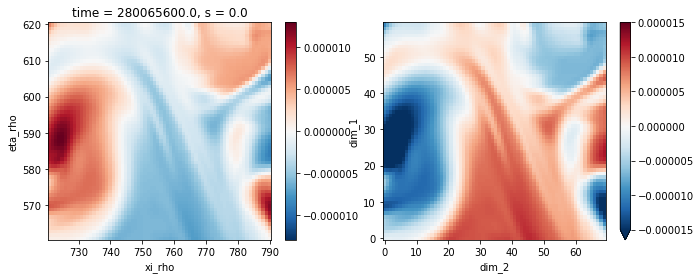

In [78]:
fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot(121)
q[0,0].plot()
ax2 = fig.add_subplot(122)
q_inverted[0].plot(vmax=1.5e-5)

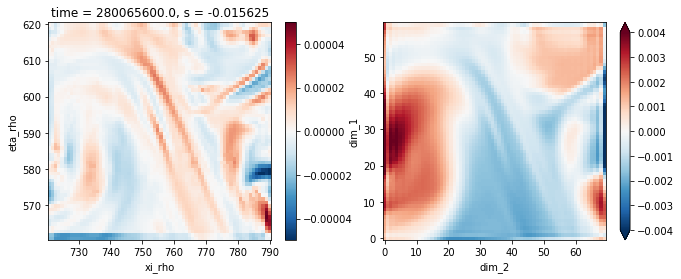

In [79]:
fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot(121)
(q[0,1]-f).plot()
ax2 = fig.add_subplot(122)
q_inverted[1].plot(vmax=4e-3)

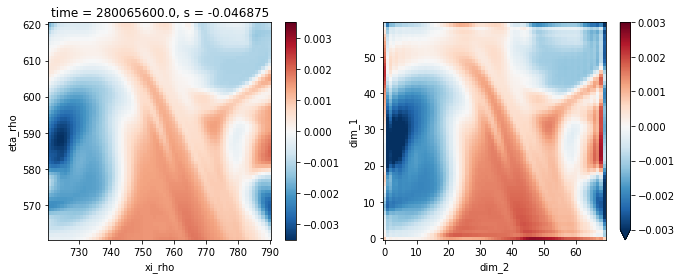

In [80]:
fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot(121)
(q[0,2]-f).plot()
ax2 = fig.add_subplot(122)
q_inverted[2].plot(vmax=3e-3)

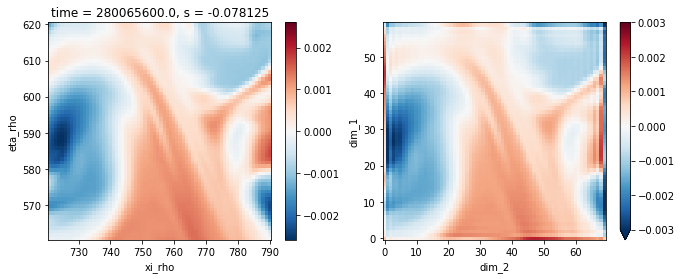

In [81]:
fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot(121)
(q[0,3]-f).plot()
ax2 = fig.add_subplot(122)
q_inverted[3].plot(vmax=3e-3)

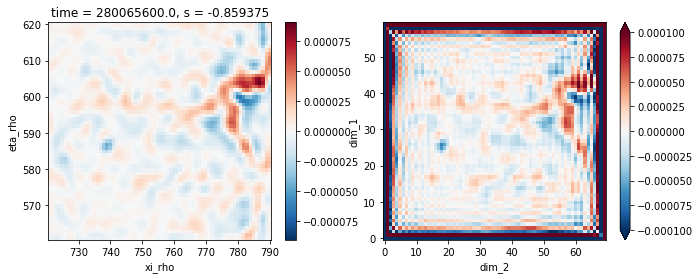

In [82]:
fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot(121)
(q[0,-5]-f).plot()
ax2 = fig.add_subplot(122)
q_inverted[-5].plot(vmax=1e-4)

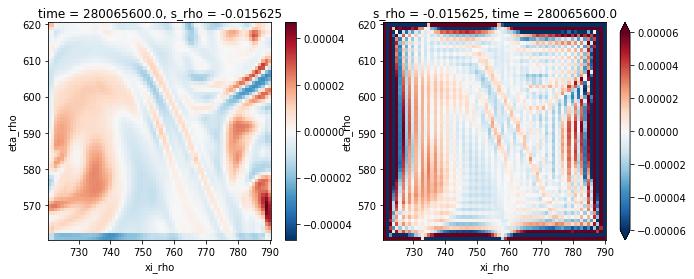

In [83]:
fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot(121)
zeta_g[0,0].plot()
ax2 = fig.add_subplot(122)
zeta_inverted[0].plot(vmax=6e-5)

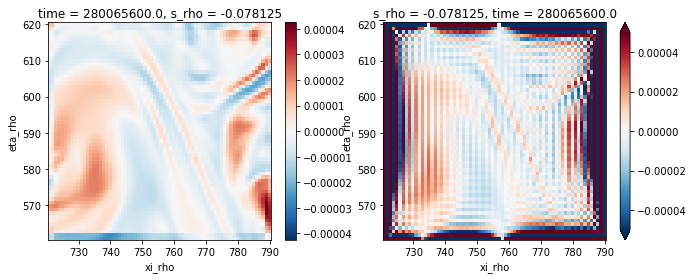

In [84]:
fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot(121)
zeta_g[0,2].plot()
ax2 = fig.add_subplot(122)
zeta_inverted[2].plot(vmax=5e-5)

In [85]:
np.diag(np.ones(3),-1)

array([[ 0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.]])